# Product Demand Forecast


It how much quantity of a given a product to stock is a major for wholesale and retail business.

In this project you are tasked as a data scientist  to:
1. clean and prepare the data
2. conduct the nescessary exploratory analysis and visualizations to extract insights
3. forecast the  weekly demand for product **Category_019** for warehouse **Whse_J** warehouse.
4. conduct any other analysis that you deem it fit.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import pmdarima as mp
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
%matplotlib inline

### Data preprocessing ###

***importing the data***

In [ ]:
raw_hist = pd.read_csv('Historical Product Demand.csv')

In [ ]:
raw_hist

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500
...,...,...,...,...,...
815007,Product_1580,Whse_J,Category_005,2015/10/21,100
815008,Product_1729,Whse_J,Category_005,2015/12/2,200
815009,Product_1998,Whse_J,Category_005,2015/10/21,1000
815010,Product_1998,Whse_J,Category_005,2015/10/26,1000


***Sanity check***

In [ ]:
raw_hist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 815012 entries, 0 to 815011
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Product_Code      815012 non-null  object
 1   Warehouse         815012 non-null  object
 2   Product_Category  815011 non-null  object
 3   Date              806271 non-null  object
 4   Order_Demand      815011 non-null  object
dtypes: object(5)
memory usage: 31.1+ MB


In [ ]:
raw_hist.describe(include='all')

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
count,1048575,1048575,1048575,1037336,1048575
unique,2160,4,33,1729,3828
top,Product_1359,Whse_J,Category_019,2013/9/27,1000
freq,16936,764447,481099,2075,112682


In [ ]:
raw_hist.isnull().sum()

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64

In [ ]:
raw_hist.dropna(inplace=True)

In [ ]:
raw_hist.isnull().sum()

Product_Code        0
Warehouse           0
Product_Category    0
Date                0
Order_Demand        0
dtype: int64

***Univariate Analysis***

In [ ]:
len(raw_hist)

806271

In [ ]:
raw_hist['Product_Code'].nunique()

2126

In [ ]:
raw_hist['Product_Category'].nunique()

33

In [ ]:
raw_hist['Warehouse'].nunique()

4

In [ ]:
raw_hist['Warehouse'].unique()

array(['Whse_J', 'Whse_S', 'Whse_C', 'Whse_A'], dtype=object)

In [ ]:
raw_hist['Warehouse'].value_counts()

Whse_J    589403
Whse_A    116648
Whse_S     68385
Whse_C     31835
Name: Warehouse, dtype: int64

<Axes: xlabel='Warehouse', ylabel='count'>

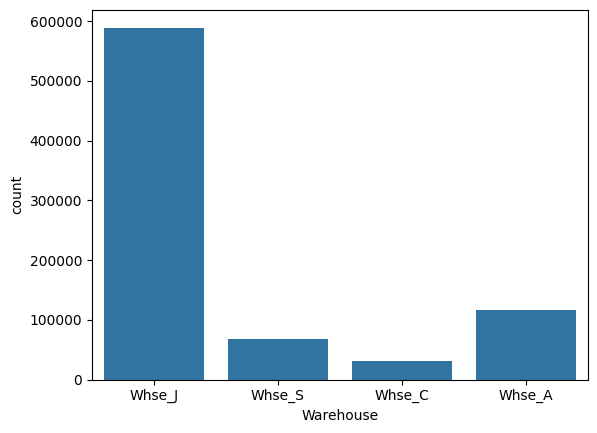

In [ ]:
sns.countplot(raw_hist, x=raw_hist['Warehouse'])

***Bivariate Analysis***

***First we need to convert the data type of Order_Demand for numeric one and the date to datetime***

In [ ]:
raw_hist['Order_Demand'] = pd.to_numeric(raw_hist['Order_Demand'], errors='coerce')

In [ ]:
raw_hist['Date'] = pd.to_datetime(raw_hist['Date'])

In [ ]:
raw_hist.groupby('Warehouse')['Order_Demand'].mean().sort_values()

Warehouse
Whse_A      997.848074
Whse_J     4515.836956
Whse_S    12109.906993
Whse_C    14151.595965
Name: Order_Demand, dtype: float64

In [ ]:
code_per_whs = raw_hist.groupby('Warehouse')['Product_Code'].nunique().reset_index(name='Unique_Product_Codes').sort_values(by='Unique_Product_Codes', ascending=True)

In [ ]:
code_per_whs

,Warehouse,Unique_Product_Codes
1,Whse_C,242
0,Whse_A,421
3,Whse_S,543
2,Whse_J,1602


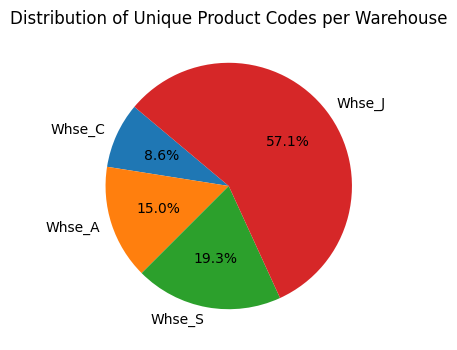

In [ ]:
plt.figure(figsize=(4,4))
plt.pie(code_per_whs['Unique_Product_Codes'], labels = code_per_whs['Warehouse'], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Unique Product Codes per Warehouse')
plt.show()

In [ ]:
category_per_whs = raw_hist.groupby('Warehouse')['Product_Category'].nunique().reset_index(name='Unique_Product_Codes').sort_values(by='Unique_Product_Codes', ascending=True)

In [ ]:
category_per_whs

,Warehouse,Unique_Product_Codes
1,Whse_C,16
0,Whse_A,24
2,Whse_J,25
3,Whse_S,28


In [ ]:
colors = ['sienna', 'lightsalmon', 'olive', 'darkgrey']

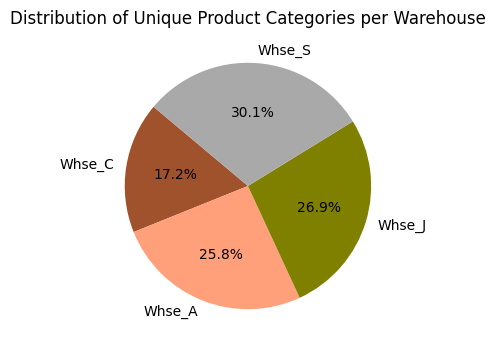

In [ ]:
plt.figure(figsize=(4,4))
plt.pie(category_per_whs['Unique_Product_Codes'], labels = category_per_whs['Warehouse'], autopct='%1.1f%%', colors = colors, startangle=140)
plt.title('Distribution of Unique Product Categories per Warehouse')
plt.show()

In [ ]:
raw_hist.groupby('Product_Category')['Product_Code'].count().sort_values()

Product_Category
Category_016         3
Category_014        12
Category_027        15
Category_025        32
Category_002        50
Category_004       287
Category_012       411
Category_017       420
Category_029       531
Category_010       718
Category_008      1232
Category_033      1466
Category_031      1853
Category_013      2880
Category_020      2968
Category_003      3055
Category_018      3885
Category_023      5816
Category_022      6410
Category_032      7008
Category_030      9417
Category_026     10910
Category_009     14510
Category_024     16344
Category_015     17487
Category_011     18327
Category_028     24301
Category_006     27006
Category_021     40101
Category_007     64238
Category_001     73200
Category_005     77899
Category_019    373479
Name: Product_Code, dtype: int64

***Filtering on the desired product and category***

In [ ]:
df = raw_hist.loc[(raw_hist['Product_Category'] == 'Category_019') & (raw_hist['Warehouse'] == 'Whse_J')]

In [ ]:
df

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
63,Product_1234,Whse_J,Category_019,2012-04-25,1000.0
64,Product_1451,Whse_J,Category_019,2012-01-12,1000.0
65,Product_1274,Whse_J,Category_019,2012-01-16,1000.0
66,Product_1274,Whse_J,Category_019,2012-01-24,1000.0
67,Product_1274,Whse_J,Category_019,2012-01-24,1000.0
...,...,...,...,...,...
814084,Product_1562,Whse_J,Category_019,2015-01-13,50.0
814085,Product_1562,Whse_J,Category_019,2015-02-02,150.0
814086,Product_1562,Whse_J,Category_019,2015-02-02,50.0
814087,Product_1562,Whse_J,Category_019,2015-02-02,250.0


***Checking for outliers***

In [ ]:
df['Order_Demand'].describe()

count    2.892780e+05
mean     7.475897e+03
std      2.796747e+04
min      0.000000e+00
25%      5.000000e+02
50%      1.100000e+03
75%      5.000000e+03
max      3.000000e+06
Name: Order_Demand, dtype: float64

In [ ]:
is_sequential = list(df.index) == list(range(len(df)))
print("Index values are sequential:", is_sequential)

Index values are sequential: False


In [ ]:
print(df.index)

Int64Index([    63,     64,     65,     66,     67,     68,     69,     70,
                71,     72,
            ...
            814077, 814078, 814081, 814082, 814083, 814084, 814085, 814086,
            814087, 814094],
           dtype='int64', length=290155)


*** Checking for outliers ***



In [ ]:
df_reset = df.reset_index()
sns.boxplot(data=df_reset['Order_Demand'])

<Axes: ylabel='Order_Demand'>

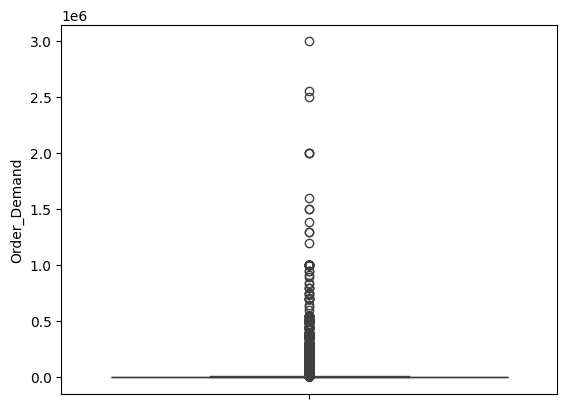

In [ ]:
sns.boxplot(y = df['Order_Demand'])

Observation: Large amount and scaled data in Order_Demand feature, so outliers need to be handled.

In [ ]:
outlier_clean = (
    (df['Order_Demand'] < df['Order_Demand'].quantile(0.97)) &
    (df['Order_Demand'] > df['Order_Demand'].quantile(0.03))
)

In [ ]:
df2 = df[outlier_clean]

In [ ]:
len(df2)

270639

<Axes: ylabel='Order_Demand'>

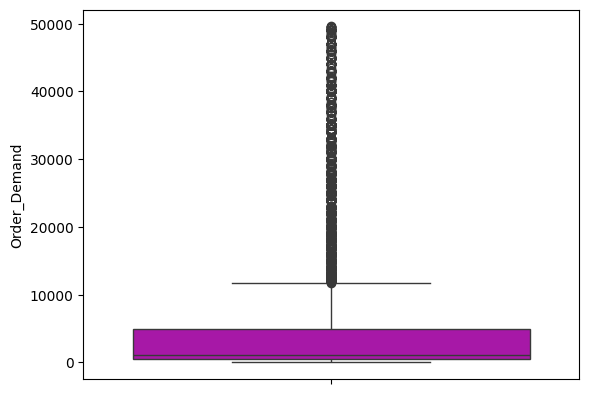

In [ ]:
sns.boxplot(y = df2['Order_Demand'],color='m')

<Axes: xlabel='Order_Demand', ylabel='Count'>

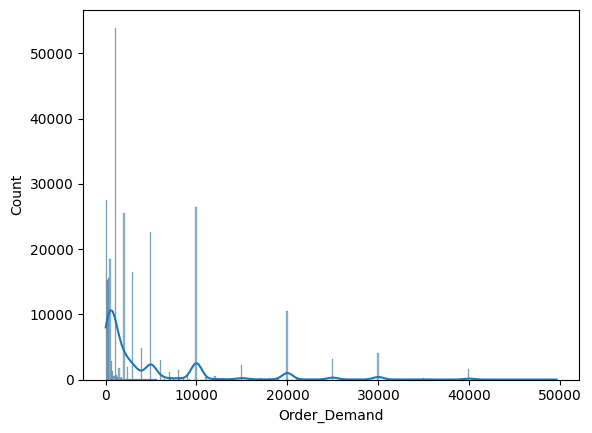

In [ ]:
sns.histplot(df2['Order_Demand'], kde=True)

In [ ]:
df2['Order_Demand'].describe()

count    270639.000000
mean       4591.048988
std        7142.400926
min          21.000000
25%         500.000000
50%        1100.000000
75%        5000.000000
max       49600.000000
Name: Order_Demand, dtype: float64

#### Preparation for Time Series Analysis ####

In [ ]:
df2['Date'].info()

<class 'pandas.core.series.Series'>
Int64Index: 270639 entries, 63 to 814094
Series name: Date
Non-Null Count   Dtype         
--------------   -----         
270639 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 4.1 MB


In [ ]:
df3 = df2.copy()

In [ ]:
df3.drop(['Product_Code', 'Warehouse', 'Product_Category'], axis=True, inplace=True)

In [ ]:
df3.set_index('Date', inplace=True)

In [ ]:
df3.groupby('Date').sum()

,Order_Demand
Date,
2011-12-15,1000.0
2011-12-21,800.0
2011-12-26,5500.0
2011-12-27,13200.0
2011-12-28,10000.0
...,...
2015-12-21,1620625.0
2015-12-22,1448360.0
2015-12-24,1471250.0


***resample for weekly***

In [ ]:
weekly = df3.resample('w').sum().dropna()

In [ ]:
weekly

,Order_Demand
Date,
2011-12-18,1000.0
2011-12-25,800.0
2012-01-01,28700.0
2012-01-08,3521215.0
2012-01-15,5728755.0
...,...
2015-12-06,8097205.0
2015-12-13,6113680.0
2015-12-20,5221655.0


***weekly one takes the sum which results large amounts***

In [ ]:
weekly.describe()

,Order_Demand
count,2.120000e+02
mean,5.860929e+06
std,1.503203e+06
min,0.000000e+00
25%,5.468384e+06
50%,6.143160e+06
75%,6.660570e+06
max,9.106890e+06


<Axes: xlabel='Date'>

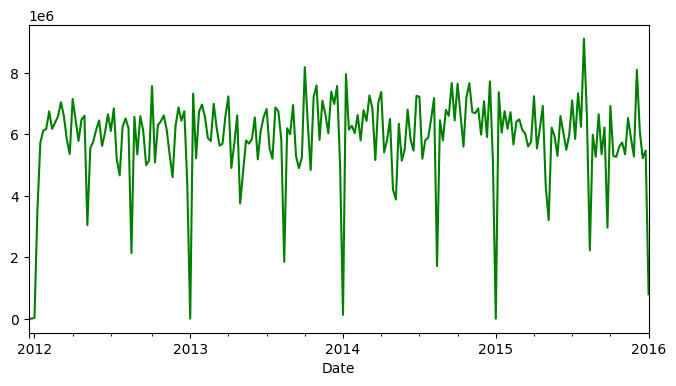

In [ ]:
weekly['Order_Demand'].plot(figsize=(8,4), color='g')

***Quick decompose check and the adf test my original weekly data for stationarity***

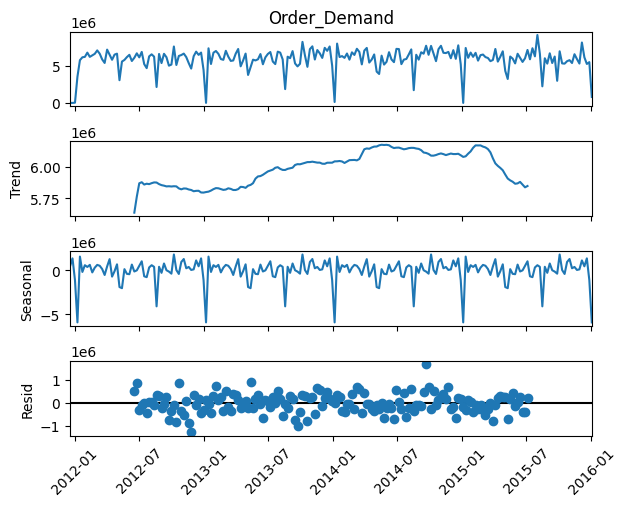

In [ ]:
raw_result = sm.tsa.seasonal.seasonal_decompose(weekly['Order_Demand'])

components = raw_result.plot()

plt.xticks(rotation=45)

plt.show()

In [ ]:
raw_result = adfuller(weekly['Order_Demand'])

In [ ]:
raw_result

(-4.549131644359225,
 0.00016012312371714826,
 15,
 196,
 {'1%': -3.464161278384219,
  '5%': -2.876401960790147,
  '10%': -2.5746921001665974},
 6095.60095755467)

Observation: the original weekly data is stationary

***taking the square root***

In [ ]:
weekly['sr_Order_Demand'] = np.sqrt(weekly['Order_Demand'])

In [ ]:
weekly_sr = weekly[['sr_Order_Demand']]

In [ ]:
weekly_sr

,sr_Order_Demand
Date,
2011-12-18,31.622777
2011-12-25,28.284271
2012-01-01,169.410743
2012-01-08,1876.490075
2012-01-15,2393.481773
...,...
2015-12-06,2845.558820
2015-12-13,2472.585691
2015-12-20,2285.094090


<Axes: xlabel='Date'>

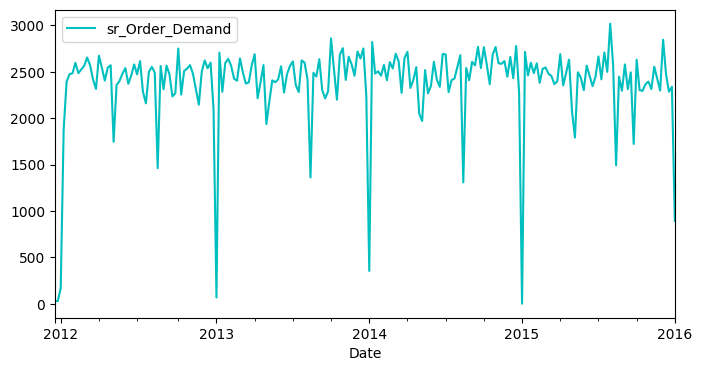

In [ ]:
weekly_sr.plot(figsize=(8,4), color='c')

#### Train & test split ####

In [ ]:
weekly_sr.tail(15)

,sr_Order_Demand
Date,
2015-09-27,1722.058361
2015-10-04,2630.401110
2015-10-11,2301.857945
2015-10-18,2294.130118
2015-10-25,2364.891118
2015-11-01,2394.364216
2015-11-08,2313.119106
2015-11-15,2555.070449
2015-11-22,2423.543893


In [ ]:
len(weekly_sr)

212

In [ ]:
train = weekly_sr.loc[: '2015-12-06']
train.tail()

,sr_Order_Demand
Date,
2015-11-08,2313.119106
2015-11-15,2555.070449
2015-11-22,2423.543893
2015-11-29,2297.302766
2015-12-06,2845.558820


In [ ]:
len(train)

208

In [ ]:
holdout = weekly_sr.loc['2015-11-15':]
holdout.tail(8)

,sr_Order_Demand
Date,
2015-11-15,2555.070449
2015-11-22,2423.543893
2015-11-29,2297.302766
2015-12-06,2845.558820
2015-12-13,2472.585691
2015-12-20,2285.094090
2015-12-27,2338.658804
2016-01-03,892.188321


In [ ]:
len(holdout)

8

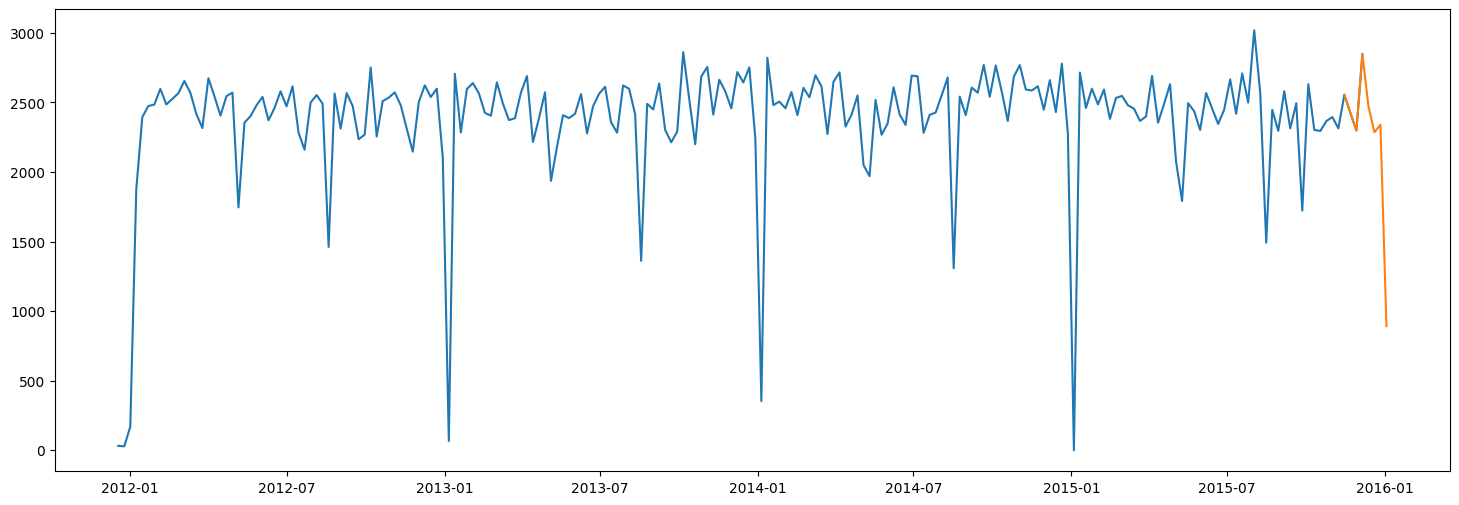

In [ ]:
plt.figure(figsize=(18, 6))
plt.plot(train.index, train.values, label='Training data')
plt.plot(holdout.index, holdout.values, label='Holdout data')

***Check the decompostion***

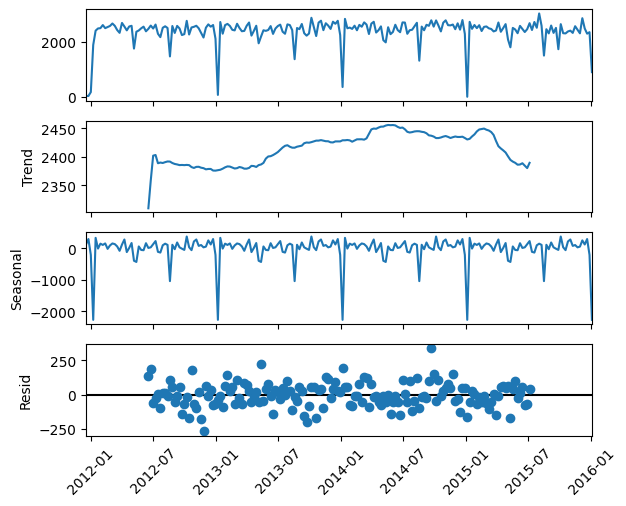

In [ ]:

result = sm.tsa.seasonal.seasonal_decompose(train)

components = result.plot()

plt.xticks(rotation=45)

plt.show()

Oberservation: There are both trend and seasonality in the time series

Checking assumption for stationarity using Augmented Dickey Fuller test

    Hypothesis

    H0: The time series is non-stationary due to trend

    H1: The time series is sationary

In [ ]:
test_result = adfuller(train)

In [ ]:
test_result

(-5.807341979338531,
 4.484417103569661e-07,
 15,
 196,
 {'1%': -3.464161278384219,
  '5%': -2.876401960790147,
  '10%': -2.5746921001665974},
 2897.138424324027)

Observation:The p-value is approximately 8.19192566463178e-09, which is significantly smaller than 0.05, so the H0 can be rejected, our original data was stationary before taking the square root - no need further differencing!

***Let's check for the lag orders and AR & MA***

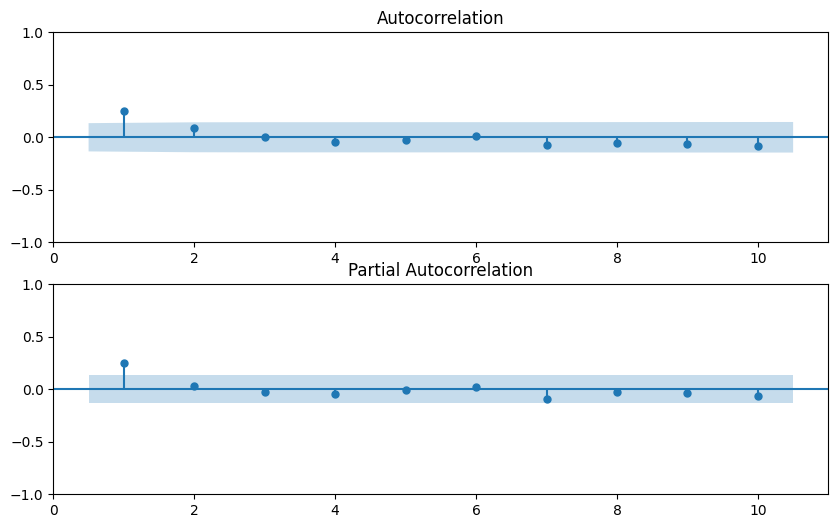

In [ ]:
fig,(ax1, ax2) = plt.subplots(2, 1, figsize=(10,6))
plot_acf(train, lags=10, zero=False, ax=ax1, alpha = 0.05)
plot_pacf(train, lags=10, zero=False, ax=ax2)
plt.show()

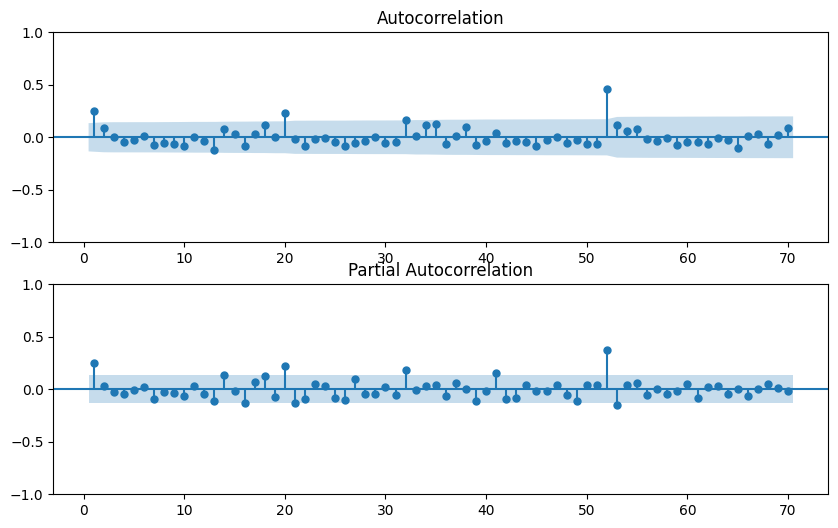

In [ ]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(10,6))
plot_acf(train, lags=70, zero=False, ax=ax1, alpha =0.05)
plot_pacf(train, lags=70, zero=False, ax=ax2)
plt.show()

In [ ]:
model = auto_arima(train,
                   start_p=0, start_q=0,
                   max_p=3, max_q=3, m=52,
                   start_P=0, seasonal=True,
                   d=1, D=1, trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[52]             : AIC=inf, Time=10.94 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=2370.524, Time=0.78 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=2346.471, Time=6.79 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=6.97 sec
 ARIMA(1,1,0)(0,1,0)[52]             : AIC=2349.606, Time=0.31 sec
 ARIMA(1,1,0)(2,1,0)[52]             : AIC=2347.619, Time=26.84 sec
 ARIMA(1,1,0)(1,1,1)[52]             : AIC=inf, Time=25.10 sec
 ARIMA(1,1,0)(0,1,1)[52]             : AIC=2347.029, Time=8.65 sec
 ARIMA(1,1,0)(2,1,1)[52]             : AIC=inf, Time=78.65 sec
 ARIMA(0,1,0)(1,1,0)[52]             : AIC=2367.292, Time=3.64 sec
 ARIMA(2,1,0)(1,1,0)[52]             : AIC=2343.931, Time=9.37 sec
 ARIMA(2,1,0)(0,1,0)[52]             : AIC=2347.216, Time=0.42 sec
 ARIMA(2,1,0)(2,1,0)[52]             : AIC=2345.321, Time=33.90 sec
 ARIMA(2,1,0)(1,1,1)[52]             : AIC=inf, Time=22.51 sec
 ARIMA(2,1,0)(0,1,1)[52]             :

### Sarimax

In [ ]:
sarimax = SARIMAX(train, order=(3,1,0), seasonal_order=(1,1,0,52), trend='ct')
sarimax_result = sarimax.fit()
print(sarimax_result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                    sr_Order_Demand   No. Observations:                  212
Model:             SARIMAX(3, 1, 0)x(1, 1, 0, 52)   Log Likelihood               -1165.969
Date:                            Tue, 13 Feb 2024   AIC                           2345.937
Time:                                    09:20:43   BIC                           2367.420
Sample:                                12-18-2011   HQIC                          2354.661
                                     - 01-03-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -54.9223    199.092     -0.276      0.783    -445.136     335.291
drift          0.3156      1.218   

### Forecast

In [ ]:
forecast_training_weekly = sarimax_result.get_prediction(start=-9)

forecast_values = forecast_training_weekly.predicted_mean

In [ ]:
forecast_values

Date
2015-11-08    2241.782213
2015-11-15    2400.995057
2015-11-22    2445.672594
2015-11-29    2254.992898
2015-12-06    2517.571821
2015-12-13    2533.015855
2015-12-20    2752.137787
2015-12-27    2002.002695
2016-01-03      94.418969
Freq: W-SUN, Name: predicted_mean, dtype: float64

In [ ]:
forecast_conf_training = forecast_training_weekly.conf_int()

In [ ]:
forecast_conf_training

,lower sr_Order_Demand,upper sr_Order_Demand
Date,,
2015-11-08,1548.545664,2935.018762
2015-11-15,1707.758508,3094.231606
2015-11-22,1752.436045,3138.909142
2015-11-29,1561.756349,2948.229447
2015-12-06,1824.335272,3210.808370
2015-12-13,1839.779306,3226.252404
2015-12-20,2058.901238,3445.374336
2015-12-27,1308.766146,2695.239244
2016-01-03,-598.817580,787.655518


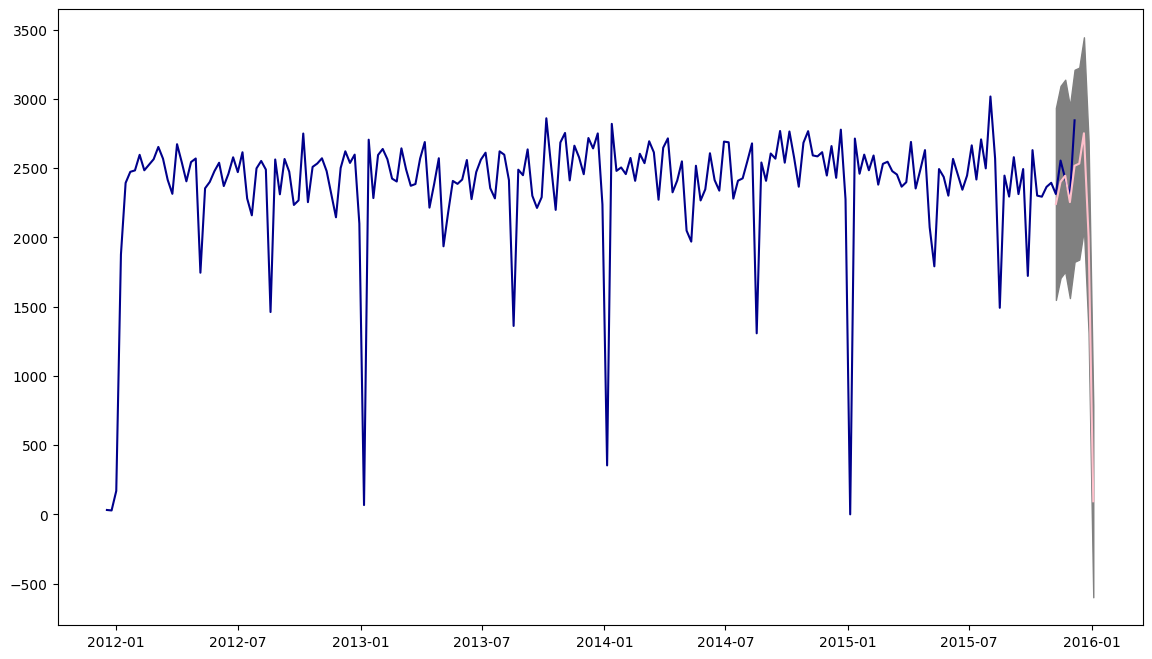

In [ ]:
plt.figure(figsize=(14,8))

plt.plot(train.index, train.values, color ='darkblue')
plt.plot(forecast_values.index, forecast_values.values, color ='pink')

plt.fill_between(forecast_values.index, forecast_conf_training['lower sr_Order_Demand'], forecast_conf_training['upper sr_Order_Demand'],
                color='grey')
plt.show()

In [ ]:
len(holdout)

8

In [ ]:
forecast_holdout = sarimax_result.get_prediction(start=-8)
mean_forecast_holdout = forecast_holdout.predicted_mean
mean_forecast_holdout


Date
2015-11-15    2400.995057
2015-11-22    2445.672594
2015-11-29    2254.992898
2015-12-06    2517.571821
2015-12-13    2533.015855
2015-12-20    2752.137787
2015-12-27    2002.002695
2016-01-03      94.418969
Freq: W-SUN, Name: predicted_mean, dtype: float64

In [ ]:
forecast_conf_holdout = forecast_holdout.conf_int()

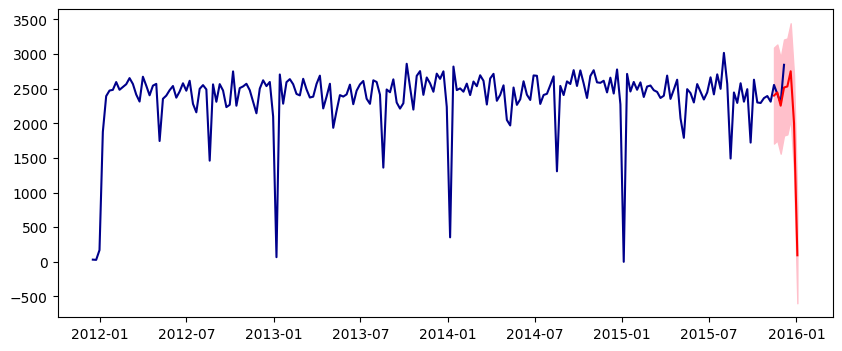

In [ ]:
plt.figure(figsize=(10,4))

plt.plot(train.index, train.values, color ='darkblue')
plt.plot(mean_forecast_holdout.index, mean_forecast_holdout.values,
        color='red',
        label = 'forecast')

plt.fill_between(mean_forecast_holdout.index, forecast_conf_holdout['lower sr_Order_Demand'], forecast_conf_holdout['upper sr_Order_Demand'],
                color='pink')
plt.show()

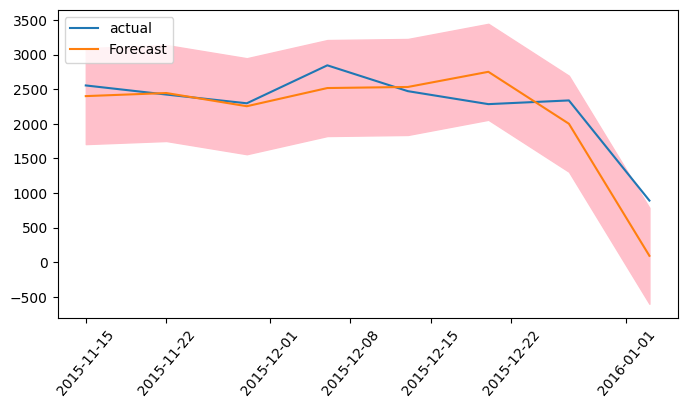

In [ ]:
plt.figure(figsize=(8,4))

plt.plot(holdout.index, holdout.values, label="actual")
plt.plot(mean_forecast_holdout.index, mean_forecast_holdout.values, label="Forecast")

plt.fill_between(mean_forecast_holdout.index, forecast_conf_holdout['lower sr_Order_Demand'],forecast_conf_holdout['upper sr_Order_Demand'], color='pink')

plt.legend(loc="upper left")
plt.xticks(rotation = 50)
plt.show()

In [ ]:
holdout['sr_Order_Demand'] = mean_forecast_holdout.values

In [ ]:
holdout_forecast_df = holdout

In [ ]:
holdout_forecast_df

,sr_Order_Demand
Date,
2015-11-15,2400.995057
2015-11-22,2445.672594
2015-11-29,2254.992898
2015-12-06,2517.571821
2015-12-13,2533.015855
2015-12-20,2752.137787
2015-12-27,2002.002695
2016-01-03,94.418969


So let's check the now the forecasted values of the transformed order demand (we took the square root)

In [ ]:
forecast_holdout = sarimax_result.get_forecast(steps=len(holdout))
mean_forecast_holdout = forecast_holdout.predicted_mean
mean_forecast_holdout

2016-01-10    3136.503069
2016-01-17    2718.810344
2016-01-24    2861.581234
2016-01-31    2897.845925
2016-02-07    2977.781179
2016-02-14    2759.325870
2016-02-21    2924.233972
2016-02-28    2942.737920
Freq: W-SUN, Name: predicted_mean, dtype: float64

Now to transform it back to get the original data and to compare it with the forecasted one

In [ ]:
mean_forecast_holdout_original_scale = np.square(mean_forecast_holdout)

# Assign the forecasted values back to your dataframe
holdout['sr_Order_Deman'] = mean_forecast_holdout_original_scale.values
holdout_forecast_df_original = holdout


In [ ]:
holdout_forecast_df_original

,sr_Order_Demand,sr_Order_Deman
Date,,
2015-11-15,2400.995057,9.837651e+06
2015-11-22,2445.672594,7.391930e+06
2015-11-29,2254.992898,8.188647e+06
2015-12-06,2517.571821,8.397511e+06
2015-12-13,2533.015855,8.867181e+06
2015-12-20,2752.137787,7.613879e+06
2015-12-27,2002.002695,8.551144e+06
2016-01-03,94.418969,8.659706e+06
